# Проверка параметрических гипотез

# Библиотеки

In [1]:
!pip install numpy statsmodels matplotlib seaborn pandas

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test, proportions_ztest, proportions_chisquare
from statsmodels.distributions.empirical_distribution import ECDF


# Warmup

## Пример, Kanji, критерий 1

Линия по производству пудры должна обеспечивать средний вес пудры в
упаковке 4 грамма, заявленное стандартное отклонение — 1 грамм.
В ходе инспекции выбрано 9 упаковок, средний вес продукта в них составляет
4.6 грамма.

$H_0$: средний вес пудры в упаковке соответствует норме.

$H_1$: средний вес пудры в упаковке не соответствует норме.

```p=0.0719```

Проверим критерий "вручную":

$Z = \frac{\bar{X}-\mu}{\sigma/\sqrt{n}}.$

$p(Z) = 2 \bigl(1-F(|Z|)\bigr).$

In [3]:
mu = 4
std = 1
n = 9
mean = 4.6

In [8]:
Z = (mean - mu) / (std / np.sqrt(n))
Z

1.799999999999999

$Z | H_0 \sim N(0, 1) $.

Находим p-value = $P(z|H_0)$

In [9]:
from scipy.stats import norm
p = 2 * (1 - norm.cdf(Z, loc=0, scale=1))
p

0.07186063822585176

Просэмплируем похожую выборку и проверим критерий с использованием библиотеки ```statsmodels```

In [10]:
np.random.seed(42)

X = np.random.randn(n) * std + mean
print('mean={}, std={}'.format(np.mean(X), np.std(X)))

mean=5.037561230377956, std=0.7222455089229228


In [11]:
print('Z={}, p={}'.format(*ztest(X, value=mu)))

Z=4.063253133913534, p=4.839349961023562e-05


# Кобзарь, задача 227

Нормируемый уровень дефектных изделий в партии $p_0 = 0.05$. Среди 20 изделий
партии проверка обнаружила 2 дефектных.

$H_0$ : доля дефектных изделий в партии не выше нормы.

$H_1$ : доля дефектных изделий в партии выше нормы.

Для биномиального критерия ```p=0.2642```.

Проверим критерий "вручную":

$T = \sum X_i$

$p(T) = 1 - F(T)$

In [12]:
n = 20
p0 = 0.05

T = 2

$ T|H_0 \sim Bi(n, p_0) $

In [13]:
from scipy.stats import binom

p = 1 - binom.cdf(
    # Probability of obtaining value "T" or worse;
    # so we need to include value "T" as well
    T-1e-5,
    n,
    p0
)
p

0.2641604750561498

### Проверим критерий с использованием библиотеки ```scipy```.

In [14]:
st.binomtest(T, n, p0, alternative='greater')

BinomTestResult(k=2, n=20, alternative='greater', statistic=0.1, pvalue=0.2641604750561498)

### Проверим критерий с использованием библиотеки  ```statsmodels```

In [15]:
binom_test(T, n, p0, alternative='larger')

0.2641604750561498

## Антиконсервативность интервалов доверия

показывает что при $p$ близких к 0,1 посчитанный 95% condfidence interval на самом деле таковым не является (а лежит от 80% до 95%)

In [16]:
N_exp = 100
n = 40
p_array =  np.arange(0.05, 0.95, 0.01)

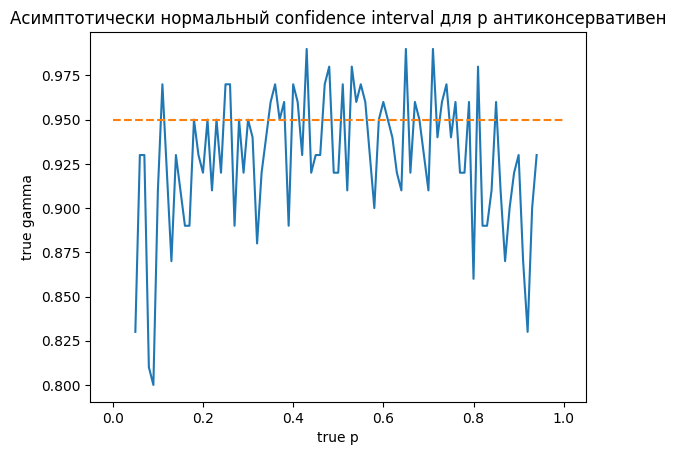

In [17]:
np.random.seed(42)

plot_Y = []
for p in p_array:
    success = 0
    for _ in range(N_exp):
        X = np.random.binomial(n, p)
        left, right = (proportion_confint(X, n))
        if left <= p <= right:
            success += 1.0
    plot_Y.append(success / N_exp)
plt.plot(p_array, plot_Y)
plt.plot([0,1], [0.95, 0.95], ls='--')
plt.gca().set_xlabel("true p")
plt.gca().set_ylabel("true gamma")
plt.title("Асимптотически нормальный confidence interval для p антиконсервативен")
plt.show()

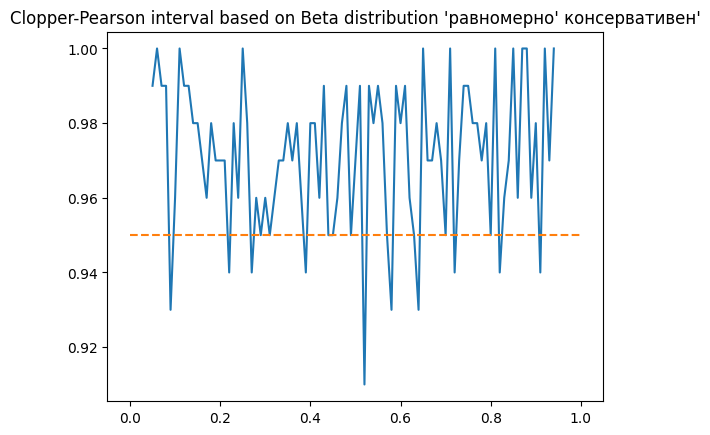

In [18]:
np.random.seed(42)

plot_Y = []
for p in p_array:
    success = 0
    for _ in range(N_exp):
        X = np.random.binomial(n, p)
        left, right = (proportion_confint(X, n, method='beta'))
        if left <= p <= right:
            success += 1
    plot_Y.append(success / N_exp)
plt.title("Clopper-Pearson interval based on Beta distribution 'равномерно' консервативен'")
plt.plot(p_array, plot_Y)
plt.plot([0,1], [0.95, 0.95], ls='--')
plt.show()

## Бонд, продолжение

Пусть Бонд выбрал взболтанный мартини в 12 случаев из 16.

Требуется:
1. Проверить гипотезу о равнозначности мартини методами ```binom_test```, ```proportions_chisquare```,
```proportions_ztest```.


2. Провести симуляцию, построить зависимость pow от истинного значения p для выборок мощностью 5, 10, 20, 100, 1000 для разных методов на уровне значимости 0.05.

3. Провести симуляцию, построить зависимость ошибки первого рода от проверяемого значения $p_0$ при истинном значении p=0.5 при заданой мозносте выборки n=10.

### Пункт 1

In [19]:
# ваш код
n = 16
p0 = 0.5
T = 12

In [20]:
binom_test(T, n, p0, alternative="two-sided")

0.076812744140625

In [21]:
# binom_test(T, n, p0, alternative="two-sided")
proportions_chisquare(T, n, value=p0)

(4.0, 0.04550026389635857, (array([[12.,  4.]]), array([[8., 8.]])))

In [22]:
proportions_ztest(T, n, value=p0)

(2.3094010767585034, 0.020921335337794014)

### Пункт 2

In [23]:
from collections import defaultdict

def get_power_estimates(method="binom_test", p0=0.5, alpha=0.05, bootstrap_size=100):
  ps = np.linspace(0.01, 0.99, num=100)
  powers = defaultdict(list)
  for n in [5, 10, 20, 100, 1000]:
    for p in ps:
      sample = binom.rvs(n, p, size=bootstrap_size, random_state=42)
      sample_decisions = []
      for observation in sample:
        if method=="binom_test":
          decision = int(binom_test(observation, n, p0, alternative="two-sided") < alpha)
        elif method=="proportions_chisquare":
          decision = int(proportions_chisquare(observation, n, value=p0)[1] < alpha)
        elif method=="proportions_ztest":
          decision = int(proportions_ztest(observation, n, value=p0)[1] < alpha)
        sample_decisions.append(decision)
      power_estimate = np.mean(sample_decisions)
      powers[n].append(power_estimate)
  return ps, powers


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


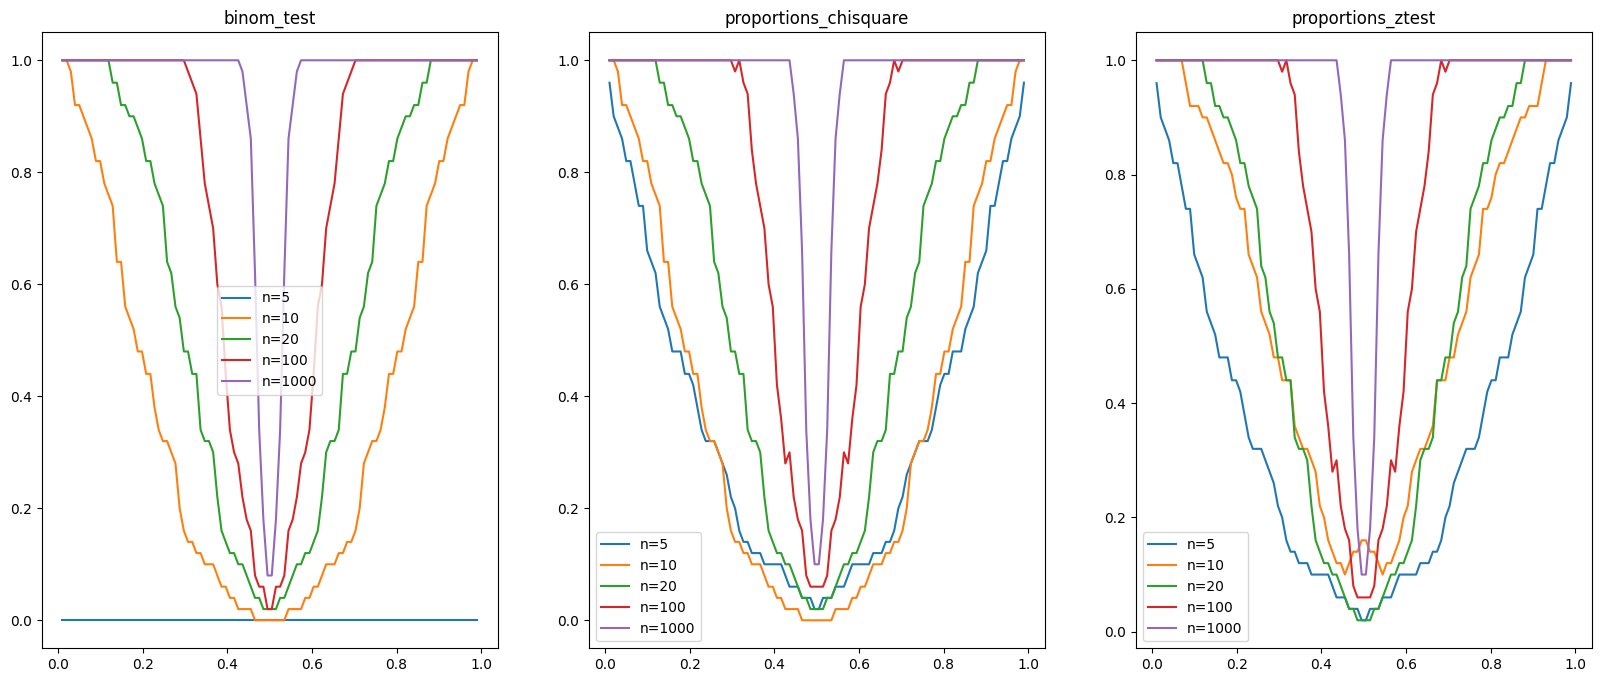

In [24]:
f, axs = plt.subplots(1, 3, figsize=(20, 8))
for ax, method in zip(axs, ["binom_test", "proportions_chisquare", "proportions_ztest"]):
  ps, power_estimates = get_power_estimates(method, bootstrap_size=50)
  for n, powers in power_estimates.items():
    ax.plot(ps, powers)
  ax.set_title(method)
  ax.legend([ f"n={i}" for i in power_estimates.keys() ])

### Пункт 3

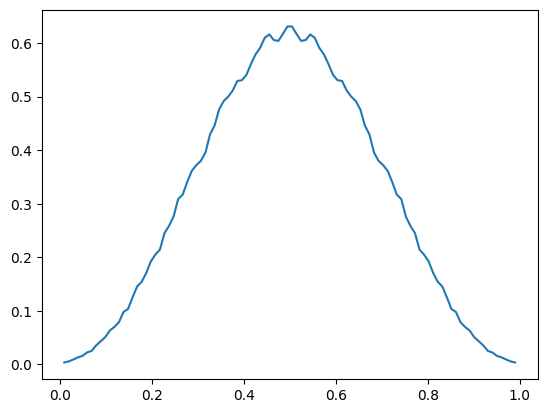

In [25]:
n = 10
p0 = 0.5
ps = np.linspace(0.01, 0.99, 100)
bootstrap_size = 100
errors = []
for p in ps:
  sample = binom.rvs(n, p, size=bootstrap_size, random_state=42)
  pvalues = []
  for observation in sample:
    pvalues.append(binom_test(observation, n, p0, alternative="two-sided"))
  errors.append(np.mean(pvalues))
plt.plot(ps, errors)

# Эксперимент Майкельсона
**Michelson A.A. Experimental determination of the velocity of light made at the U.S. Naval Academy, Annapolis. Astronomical Papers, 1, 109-145, 1880.**

Опыты Майкельсона — класс физических экспериментов, исследующих зависимость скорости распространения света от направления.

Проверим данные классического эксперимента Майкельсона по измерению скорости света с помощью вращающегося зеркала, 100 наблюдений на нормальность.

In [26]:
speed = pd.read_csv('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem2/data/speed.txt', header=None).values[:, 0]


## Гистограма распределения

<Axes: ylabel='Count'>

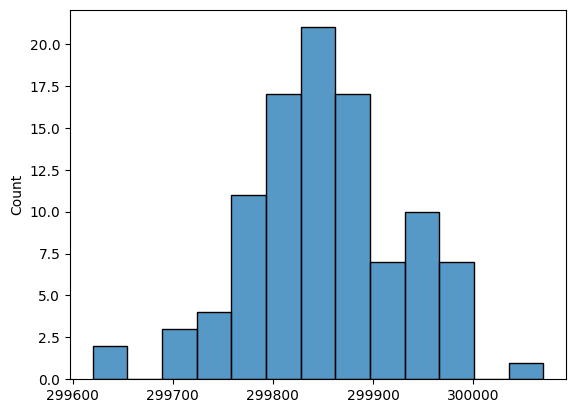

In [27]:
# ваш код
sns.histplot(speed)

<ipython-input-28-3b228314417e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(speed, hist=False, label='Empirical distribution')


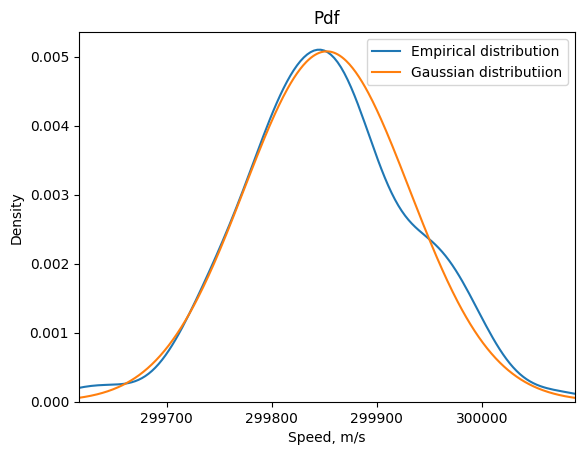

In [28]:
sns.distplot(speed, hist=False, label='Empirical distribution')
x = np.arange(min(speed) - 1000, max(speed) + 1000, 1)
plt.plot(x, st.distributions.norm(np.mean(speed), np.std(speed)).pdf(x), label='Gaussian distributiion')
plt.legend(loc='best')
plt.title('Pdf')
plt.xlabel('Speed, m/s')
plt.ylabel('Density')
plt.xlim(np.mean(speed) - 3 * np.std(speed), np.mean(speed) + 3 * np.std(speed))
plt.show()

<ipython-input-29-13ec63af6a45>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(speed, hist=False, kde_kws=dict(cumulative=True), label='Empirical distribution')


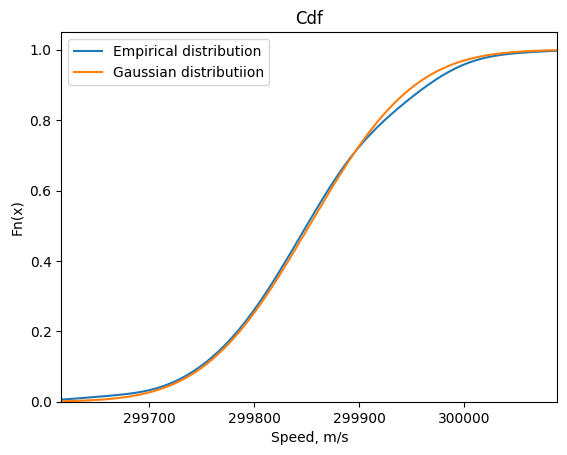

In [29]:
sns.distplot(speed, hist=False, kde_kws=dict(cumulative=True), label='Empirical distribution')
x = np.arange(min(speed) - 1000, max(speed) + 1000, 1)
plt.plot(x, st.distributions.norm(np.mean(speed), np.std(speed)).cdf(x), label='Gaussian distributiion')
plt.legend(loc='best')
plt.title('Cdf')
plt.xlabel('Speed, m/s')
plt.ylabel('Fn(x)')
plt.xlim(np.mean(speed) - 3 * np.std(speed), np.mean(speed) + 3 * np.std(speed))
plt.show()

## Проверка нормальности

### q-q plot

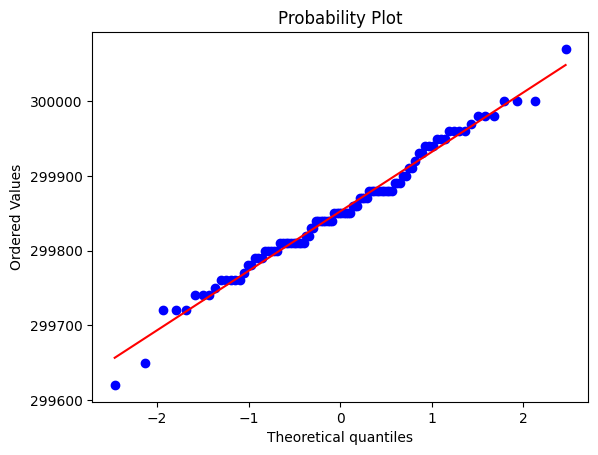

In [30]:
qq_points, qq_line =st.probplot(speed, plot=plt)
plt.show()

### Критерии Колмогорова (Лиллиефорса)

In [31]:
kstest_normal(speed, dist='norm', pvalmethod='approx')

(0.08342437427409632, 0.08289042847559838)

### Критерий Шапиро-Уилка

In [32]:
st.shapiro(speed)

ShapiroResult(statistic=0.9880728721618652, pvalue=0.5135963559150696)

### Критерий Харке-Бера

In [33]:
st.jarque_bera(speed)

SignificanceResult(statistic=0.29492498111938803, pvalue=0.8628948044155111)

# Разрушители легенд: тыльная сторона руки

## Часть 1
В 5 серии 13 сезона передачи “Разрушители легенд” проверялась справедливость выражения “know something like the back of one’s hand”. В эксперименте принимало участие 12 испытуемых. Каждому из них были предъявлены 10 фотографий похожих рук разных людей, среди которых они должны были угадать свою.

11 из 12 испытуемых выбрали свою фотографию.

$H_0$: испытуемые выбирают фотографии тыльной стороны руки наугад (p=0.1).

$H_1$: испытуемые выбирают фотографию тыльной стороны своей собственной руки осознанно (p>0.1).



In [34]:
n  = 12
T  = 11
p0 = 0.1

### Точный биномиальный критерий:

In [35]:
# ваш код
binom_test(T, n, p0, alternative="larger")

1.0900000000000006e-10

### Z-test

In [36]:
# ваш код
proportions_ztest(T, n, value=p0)

(10.235766170195031, 1.371056109091178e-24)

### Доверительный интервал Уилсона

In [37]:
proportion_confint(T, n, method='wilson')

(0.646120088858883, 0.9851349055950829)

### Критерий Вальда

In [44]:
p_mle = T / n
# D_mle = n * p_mle * (1 - p_mle) / (n ** 2)
D_mle = 1/(-n**2/T + n**2/(n-T))
# D_mle = p_mle * (1 - p_mle) * (1/n)
zw = (p_mle - p0) / np.sqrt(D_mle)
st.distributions.norm.logcdf(zw)

-6.855280545455888e-25

Ожидаемый ответ: ```~-4.641*10^(-21)```

### Часть 2
Аналогичный эксперимент был проведён с фотографиями ладоней. 7 из 12 испытуемых угадали свою фотографию.

$H_0$: испытуемые выбирают фотографии ладони наугад (p=0.1).

$H_1$: испытуемые выбирают фотографию своей собственной ладони осознанно (p>0.1).

In [45]:
n  = 12
T2  = 7
p0 = 0.1



In [46]:
binom_test(T2, n, p0, 'larger')

5.0180338000000016e-05

Можно ли утверждать, что тыльную сторону руки люди знают лучше, чем ладонь? Сравним результаты экспериментов.
Поскольку это одни и те же испытуемые, выборки связные.

Но информации о связности нет, поэтому мы вынуждены использовать критерии для независимых выборок. Z-критерий:

In [48]:
# ваш код
P = (T+T2)/(2*n)
Z = (T/n-T2/n)/np.sqrt(P*(1-P)*2/n)
1 - st.distributions.norm.cdf(Z)


0.029673219395960015

ожидаемый ответ: ```~0.03```

# Rats
**Weindruch R., Walford R.L. The Retardation of Aging and Disease by Dietary Restriction. Springfield: Charles C. Thomas, 1988.**

In [69]:
rats = pd.read_csv('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem2/data/rats.txt', delimiter='\t')
rats.head()

,lifespan,diet
0,105,restricted
1,193,restricted
2,211,restricted
3,236,restricted
4,302,restricted


In [50]:
x1 = rats.loc[rats['diet'] == 'restricted']['lifespan'].values
x2 = rats.loc[rats['diet'] == 'ad libitum']['lifespan'].values

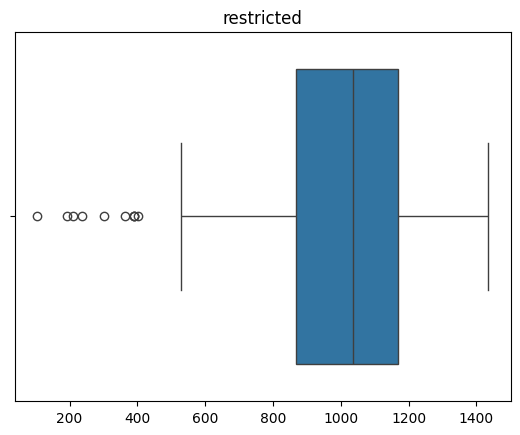

In [51]:
plt.title('restricted')
sns.boxplot(x=x1)
plt.show()

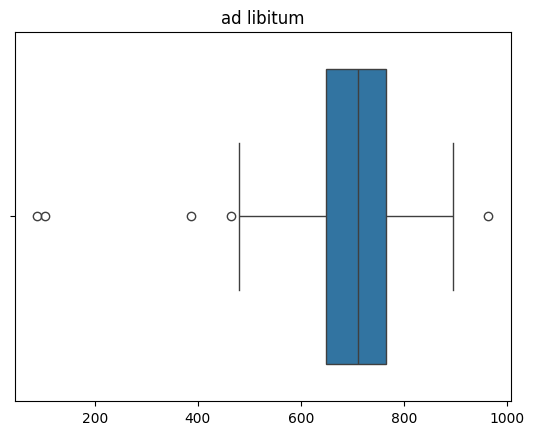

In [52]:
plt.title('ad libitum')
sns.boxplot(x=x2)
plt.show()

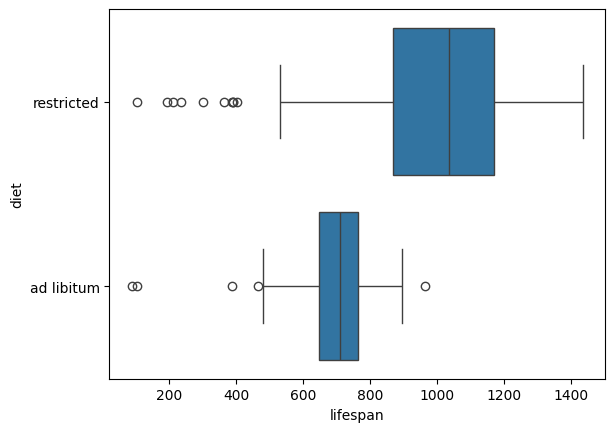

In [53]:
sns.boxplot(x='lifespan', y='diet', data=rats)
plt.show()

## Гистограммы распределений

<Axes: xlabel='lifespan', ylabel='Count'>

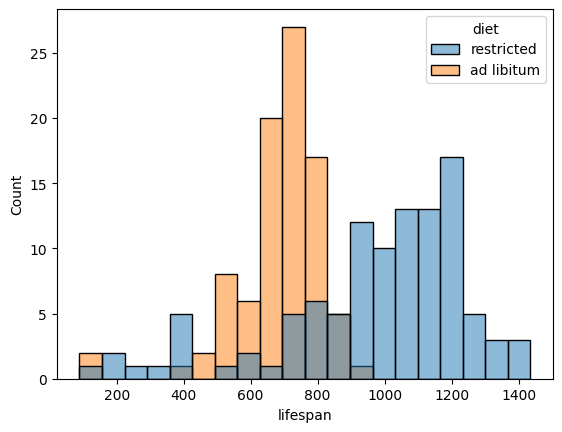

In [56]:
# ваш код
sns.histplot(rats, x="lifespan", hue="diet", bins=20)

## Проверка нормальности
$H_0$: каждая из выборок нормальна

$H_1$: нет

### Shapiro

In [59]:
# ваш код
st.shapiro(x1), st.shapiro(x2)

(ShapiroResult(statistic=0.9036345481872559, pvalue=1.1565858812900842e-06),
 ShapiroResult(statistic=0.8444005846977234, pvalue=3.081500921098268e-08))

### q-q plot

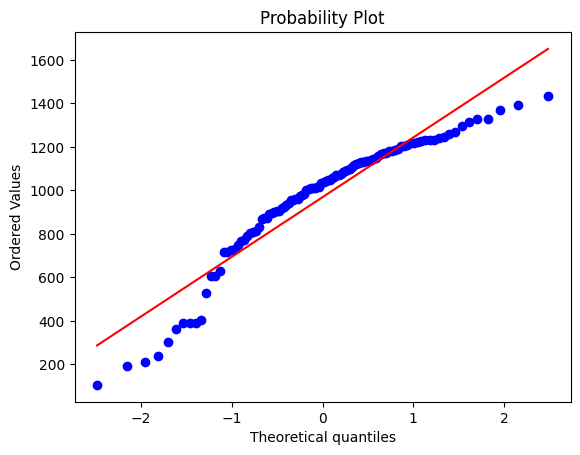

In [61]:
# ваш код
_ = st.probplot(x1, plot=plt)

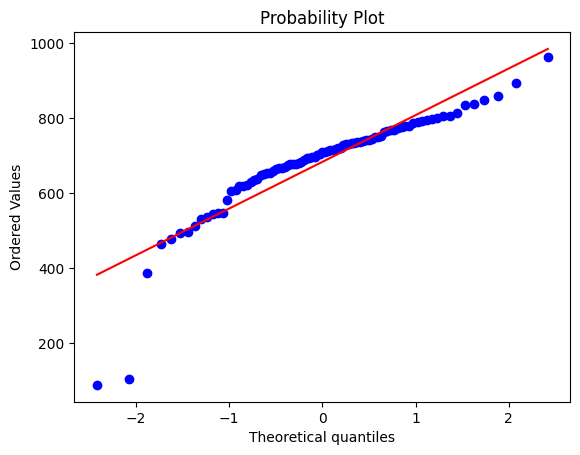

In [62]:
# ваш код
_ = st.probplot(x2, plot=plt)

Попробуем исключить крыс, проживших меньше 400 дней (например, можно предположить, что смерть раньше этого срока вызывается причинами, не связанными с диетой).

In [63]:
x1c = x1[np.where(x1>=400)[0]]
x2c = x2[np.where(x2>=400)[0]]

### Shapiro

In [64]:
# ваш код
st.shapiro(x1c), st.shapiro(x2c)

(ShapiroResult(statistic=0.9738006591796875, pvalue=0.04921640083193779),
 ShapiroResult(statistic=0.976574182510376, pvalue=0.11983133852481842))

Ожидаемые p-value:
```0.049,  0.119```

Усечённые выборки можно считать практически нормальными.

## Сравнение средних
$H_0$: продолжительность жизни крыс не меняется при ограничении диеты.

$H_1$: крысы на строгой диете живут дольше.



### Усеченные выборки

In [65]:
ttest_ind(x1c, x2c, alternative='larger', usevar='unequal')

(14.527701019046814, 3.941182274101304e-30, 141.33154919379604)

In [66]:
ttest_ind(x1c,x2c, alternative='two-sided', usevar='unequal')

(14.527701019046814, 7.882364548202608e-30, 141.33154919379604)

### Полные выборки:

In [67]:
ttest_ind(x1,x2, alternative='larger', usevar='unequal')

(9.161061040974156, 1.4580405594293205e-16, 154.9404956691433)

In [68]:
ttest_ind(x1,x2, alternative='two-sided', usevar='unequal')

(9.161061040974156, 2.916081118858641e-16, 154.9404956691433)

# Placebo
**Pearson D.A, Santos C.W., Casat C.D., et al. (2004). Treatment effects of methylphenidate on cognitive functioning in children with mental retardation and ADHD. Journal of the American Academy of Child and Adolescent Psychiatry, 43(6), 677–685.**

## Метилфенидат и синдром дефицита внимания

24 умственно отсталых ребёнка с СДВГ в течение недели принимали либо метилфенидат, либо плацебо, а в конце недели проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, после недельного курса каждый испытуемые проходили второй тест.

Каков эффект препарата?

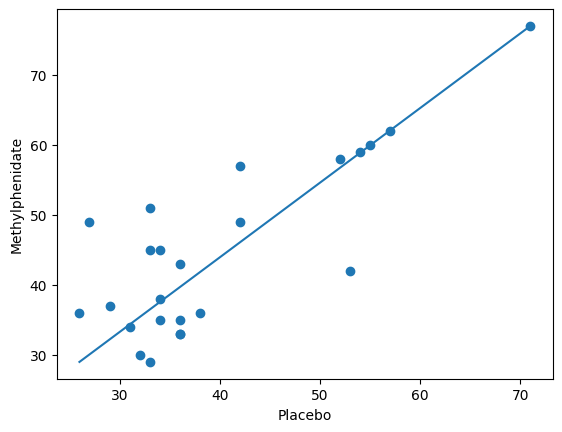

In [71]:
att = pd.read_csv('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem2/data/ADHD.txt', sep=' ').values

plt.scatter(att[:, 0], att[:, 1])
plt.xlabel('Placebo')
plt.ylabel('Methylphenidate')
plt.plot([min(att[:,0]), max(att[:,0])], [min(att[:,1]), max(att[:,1])])

plt.show()

### Проверка гипотез
Чтобы использовать критерий Стьюдента для связанных выборок, проверим, нет ли существенных отклонений от нормальности попарных разностей:

### Проверка нормальности

<ipython-input-72-566bc8c97e9b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(deltas, label='Deltas empirical distribution')


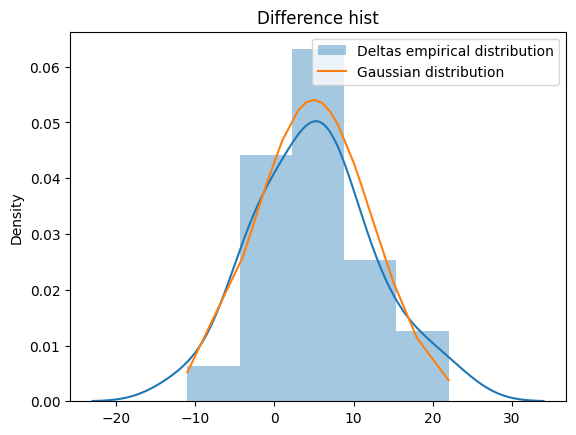

In [72]:
deltas = att[:,1] - att[:,0]
sns.distplot(deltas, label='Deltas empirical distribution')
plt.plot(sorted(deltas), st.distributions.norm(np.mean(deltas), np.std(deltas)).pdf(sorted(deltas)), label='Gaussian distribution')
plt.legend(loc='best')
plt.title('Difference hist')

plt.show()

#### q-q plot

In [73]:
# ваш код
st.probplot(deltas)

<function scipy.stats._morestats.probplot(x, sparams=(), dist='norm', fit=True, plot=None, rvalue=False)>

#### Shapiro

In [ ]:
# ваш код

Следовательно, критерий Стьюдента применим.

### Критерий Стьюдента
$H_0$ - эффекта нет (матожидания равны)

$H_1$ - есть эффект

In [74]:
st.ttest_rel(att[:,0], att[:,1])

TtestResult(statistic=-3.222362445123041, pvalue=0.003771488176381471, df=23)

Если бы у нас не было информации о связях между выборками, пришлось бы применять версию критерия Стьюдента для независимых выборок:



ShapiroResult(statistic=0.8574870824813843, pvalue=0.003020160598680377)


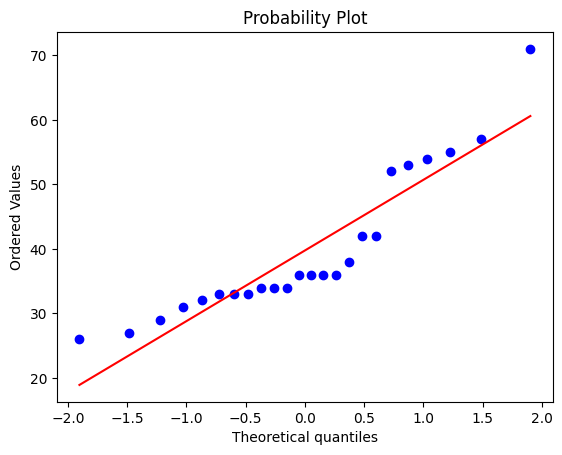

In [75]:
print(st.shapiro(att[:,0]))
_ = st.probplot(att[:,0], plot=plt)
plt.show()


ShapiroResult(statistic=0.9164453744888306, pvalue=0.04876827448606491)


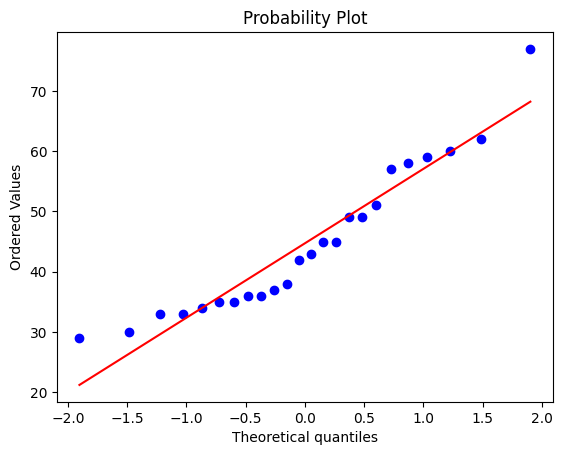

In [76]:
print(st.shapiro(att[:,1]))
_ = st.probplot(att[:,1], plot=plt)
plt.show()

In [77]:
st.ttest_ind(att[:,0], att[:,1])

TtestResult(statistic=-1.452163501815909, pvalue=0.1532433046938409, df=46.0)